In [1]:
"""
Emojifier  v3 (Transformer-based model). 
The model takes a sentence as input and identifies a suitable emoji. 
Examples include:
    Job well done! 👍
    Let's get dinner and talk. 🍴
    I love you! ❤️
    Let's watch the baseball game tomorrow! ⚾️
"""

from utils_emojify import *
import os
import numpy as np
import csv
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# LOAD THE DATASET
train_data_path = os.path.join(os.getcwd(), 'data', 'train_emoji.csv')
test_data_path = os.path.join(os.getcwd(), 'data', 'test_emoji.csv')


def read_csv_file(filename):
    """
    Reads a CSV file containing phrases and corresponding emojis, and converts them into numpy arrays.

    Args:
        filename (str): The path to the CSV file.

    Returns:
        X (numpy.ndarray): An array of phrases.
        Y (numpy.ndarray): An array of corresponding emojis as integers.
    """
    # Initialize lists to store phrases and corresponding emojis
    phrases = []
    emojis = []

    # Open the CSV file
    with open(filename, newline='') as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        # Read each row in the CSV file
        for row in csvReader:
            # Append the phrase (first column) to the phrases list
            phrases.append(row[0])
            # Append the emoji (second column) to the emojis list
            emojis.append(row[1])

    # Convert the lists to numpy arrays
    X = np.asarray(phrases)
    Y = np.asarray(emojis, dtype=int)
    return X, Y

X_train, Y_train = read_csv_reader(train_data_path)
X_test, Y_test = read_csv_reader(test_data_path)

In [3]:
# Look at some examples in the dataset
for idx in range(5):
    print(X_train[idx], convert_label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴


In [4]:
X_train = np.asarray([X_train[i].lower() for i in range(len(X_train))])
X_test = np.asarray([X_test[i].lower() for i in range(len(X_test))])
for idx in range(5):
    print(X_train[idx], convert_label_to_emoji(Y_train[idx]))

never talk to me again 😞
i am proud of your achievements 😄
it is the worst day in my life 😞
miss you so much ❤️
food is life 🍴


In [5]:
# Note that the sentences have different lengths. Most DL frameworks require that all sequences
# in the same mini-batch have the same length. Padding or truncation is needed.
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())  # Find the length of the longest sentence.
print(f"The length of the longest sentence in the training set: {maxLen}")

The length of the longest sentence in the training set: 10


In [6]:
# TOKENIZING SENTENCES
# Let's tokenize and pad the sequences to the desired length.
# Tokenizer
dbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
dbert_tokenizer.clean_up_tokenization_spaces = True  # Remove unnecessary spaces, ensuring cleaner text output

def tokenize_sentences(tokenizer, X, return_tf=True, max_len=None):
    """
    Tokenizes a list of sentences or text using the provided tokenizer.

    Parameters:
    - tokenizer: Tokenizer object (e.g., HuggingFace tokenizer).
    - X: List of sentences or text to be tokenized.
    - return_tf: Boolean. If True, returns tokenized tensors in TensorFlow format (default is True).
    - max_len: Integer. Maximum sequence length for truncation and padding. 
               If None, uses the tokenizer's default model max length.

    Returns:
    - X_tokens: Tokenized output with truncation, padding, and optional TensorFlow tensors.
    """
    # Perform tokenization with the selected settings
    X_tokens = tokenizer(
        text=X,
        truncation=True,  # Ensure truncation for sequences exceeding max_len
        padding="max_length" if max_len else True,  # Explicit padding to max_len or dynamic padding
        max_length=max_len if max_len else tokenizer.model_max_length,  # Use max_len or model's default max length
        return_tensors="tf" if return_tf else None
    )

    return X_tokens

In [7]:
#  Verification
dummy = ["funny lol", "let's play baseball", "food is ready for you"]
dummy_tokens = tokenize_sentences(dbert_tokenizer, dummy, return_tf=False, max_len=10)
print("Sentences:\n", dummy)
print("Sentence indices:\n", dummy_tokens)

Sentences:
 ['funny lol', "let's play baseball", 'food is ready for you']
Sentence indices:
 {'input_ids': [[101, 6057, 8840, 2140, 102, 0, 0, 0, 0, 0], [101, 2292, 1005, 1055, 2377, 3598, 102, 0, 0, 0], [101, 2833, 2003, 3201, 2005, 2017, 102, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]}


In [8]:
import pandas as pd
dummy_df = pd.DataFrame({key: pd.Series(value) for key, value in dummy_tokens.items()})
dummy_df

,input_ids,attention_mask
0,"[101, 6057, 8840, 2140, 102, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]"
1,"[101, 2292, 1005, 1055, 2377, 3598, 102, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]"
2,"[101, 2833, 2003, 3201, 2005, 2017, 102, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]"


In [9]:
# Tokenize input data
X_train_tok  = tokenize_sentences(dbert_tokenizer, X_train.tolist())
X_test_tok = tokenize_sentences(dbert_tokenizer, X_test.tolist())
print("Input sequence length:", X_train_tok['input_ids'].shape[1])

Input sequence length: 13


In [10]:
# One-hot encoding the targets
C = len(label_to_emoji_dict.keys())  # Number of classes
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int32)

# Verification
idx = 10
print(f"The sentence '{X_train[idx]}' has label index '{Y_train[idx]}',"
      f" which is emoji {convert_label_to_emoji(int(Y_train[idx]))}", )

The sentence 'she did not answer my text ' has label index '3', which is emoji 😞


In [18]:
# BUILDING THE MODEL AND TRAINING THE MODEL
from tf_keras.optimizers import Adam

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=C)
# Initialize optimizer with specific learning rate
optimizer = Adam(learning_rate=1e-5)

# Define loss
loss = SparseCategoricalCrossentropy(from_logits=True)

# Compile the model with optimizer configuration
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [19]:
# Callbacks
from tf_keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
chk_pt_path = os.path.join(os.getcwd(), "model", "best_model.h5")
check_point = ModelCheckpoint(
    filepath=chk_pt_path,       # Path to save the model
    monitor='val_loss',         # Monitor the training loss instead of validation loss
    save_best_only=True,        # Save only when the monitored metric improves
    save_weights_only=True,     # Saves the model/weights only
    verbose=0
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [check_point, early_stopping, reduce_lr]

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_tok), Y_train)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_tok), Y_test)).batch(8)

In [21]:
# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=30, callbacks=callbacks)

Epoch 1/30
17/17 [==============================] - 8s 220ms/step - loss: 1.8021 - accuracy: 0.1894 - val_loss: 1.7262 - val_accuracy: 0.2982 - lr: 1.0000e-05
Epoch 2/30
17/17 [==============================] - 3s 186ms/step - loss: 1.6819 - accuracy: 0.2803 - val_loss: 1.6077 - val_accuracy: 0.3158 - lr: 1.0000e-05
Epoch 3/30
17/17 [==============================] - 3s 184ms/step - loss: 1.5708 - accuracy: 0.3788 - val_loss: 1.4986 - val_accuracy: 0.4035 - lr: 1.0000e-05
Epoch 4/30
17/17 [==============================] - 3s 190ms/step - loss: 1.4053 - accuracy: 0.5379 - val_loss: 1.3611 - val_accuracy: 0.5263 - lr: 1.0000e-05
Epoch 5/30
17/17 [==============================] - 3s 199ms/step - loss: 1.2222 - accuracy: 0.7424 - val_loss: 1.1841 - val_accuracy: 0.6491 - lr: 1.0000e-05
Epoch 6/30
17/17 [==============================] - 3s 198ms/step - loss: 1.0087 - accuracy: 0.8636 - val_loss: 0.9876 - val_accuracy: 0.8246 - lr: 1.0000e-05
Epoch 7/30
17/17 [============================

In [22]:
# Plot los
def plot_history(hist):
    """
    Plots training and validation loss and accuracy from the history object.

    Arguments:
        hist: Keras History object returned by model.fit().
    """
    # Extract data from the history object
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

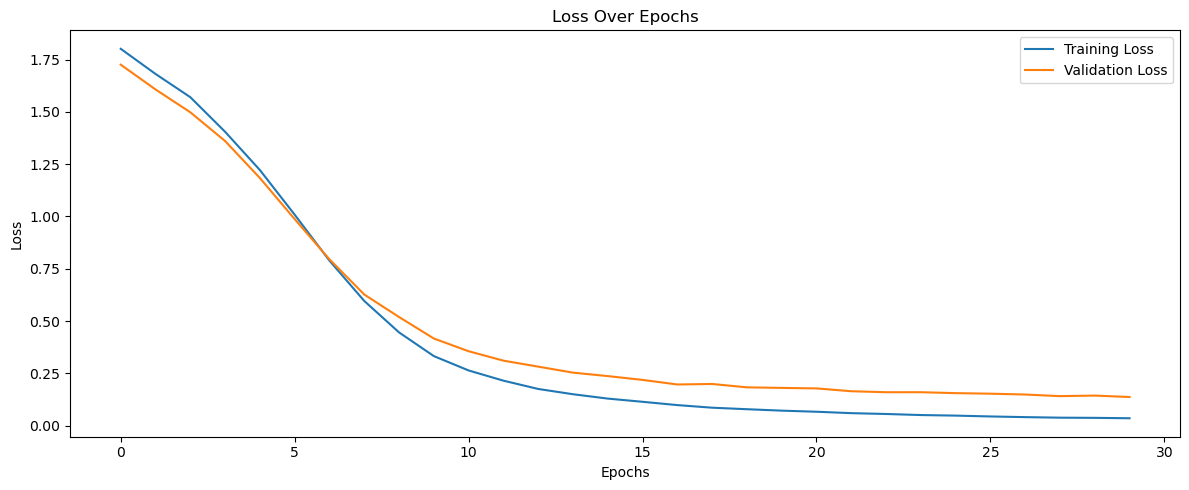

In [23]:
plot_history(history)

In [24]:
# Evaluate the model
model.load_weights(os.path.join(os.getcwd(), "model", "best_model.h5"))
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 [==============================] - 0s 30ms/step - loss: 0.1365 - accuracy: 0.9825
Test Loss: 0.13646915555000305
Test Accuracy: 0.9824561476707458


In [25]:
# Make predictions on a single text
sample_text = "The movie was fantastic!"
sample_encodings = tokenize_sentences(dbert_tokenizer, sample_text.lower(), max_len=maxLen)
logits = model(sample_encodings).logits
predictions = tf.nn.softmax(logits, axis=-1)
predicted_class = tf.argmax(predictions, axis=-1).numpy()[0]
print(f"Sample Text: {sample_text} \nPredicted Sentiment Class: {label_to_emoji_dict[str(predicted_class)]}")

Sample Text: The movie was fantastic! 
Predicted Sentiment Class: 😄


In [26]:
some_sentences = [
    "I didn't enjoy the movie. It was too slow. ",
    "The movie was amazing!",
    "Do you want to have dinner tomorrow?",
    "I'm in love with the girl",
    "Let's play baseball tomorrow!",
]
sample_sentences = [some_sentences[i].lower() for i in range(len(some_sentences))]
sentences_encodings = tokenize_sentences(dbert_tokenizer, sample_sentences, max_len=maxLen)
logits = model(sentences_encodings).logits
predictions = tf.nn.softmax(logits, axis=-1)
predicted_classes = tf.argmax(predictions, axis=-1).numpy()

for i in range(len(some_sentences)):
    print(f"{some_sentences[i]} -------- {label_to_emoji_dict[str(predicted_classes[i])]}")


I didn't enjoy the movie. It was too slow.  -------- 😞
The movie was amazing! -------- 😄
Do you want to have dinner tomorrow? -------- 🍴
I'm in love with the girl -------- ❤️
Let's play baseball tomorrow! -------- ⚾
